#Computational Science - Machine Learning for physicists
##Project: Unsupervised and supervised analysis of protein sequences
**Thomas Robiglio** (robigliothomas@gmail.com) and **Gioele Zambotti** (gioelezambotti@gmail.com)

##**Task 1: One-hot encoding of protein sequence data**
The idea is that we have to map each sequence of length $m$ into a matrix (*i.e.* and array of arrays) $m\times n$ where $n=20$ is the length of our amminoacid acid basis and $m$ is the length of our protein. The $i^{\text{th}}$ row of our matrix encodes the $i^{\text{th}}$ letter into the protein sequence. We then flatten the matrix to have a $(m\times n)$-dimensional sparse vector.

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
def encode_seq(sequence): #we can use instead of this the one-hot encoded function
  alphabet = ['A', 'C', 'D', 'E', 'F', 'G','H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y', '-']
  char_to_int = dict((c, i) for i, c in enumerate(alphabet))
  integer_encoded = [char_to_int[char] for char in sequence]
  onehot_encoded = list()

  for value in integer_encoded:
      letter = np.zeros(20, dtype=int) #initialize the array filled with zeroes
      if value < len(alphabet)-1: #if the character is not '-' we insert a 1 in the desired position
        letter[value] = 1
      onehot_encoded.append(letter)
  return np.array(onehot_encoded).flatten()

We check that the function `encode_seq()` works as we want 😇

In [ ]:
sequence = '-A'
print(encode_seq(sequence))

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]


We now have to import our data from the file `MSA_nat_with_annotation.faa`. We will store into an array `X` the sequences properly encoded and into an array `y` the labels (`0` if the sequence is **not** functional and `1` if the sequence is functional). 

In [ ]:
def encode_fasta_file(path_to_file):
  y = []
  X = []
  with open(path_to_file) as f:
    for line in f:
      line = line.strip() #removes blank spaces at the beginning and at the end of each line
      if not line:
        continue #does nothing if the line is empty
      if line.startswith(">"): #handles a label line
        text_sequence = '' #initializes the string in which we will store our sequence - trick to avoid messing up the two line sequence :)
        if line.endswith("true"):
          y.append(1)
        elif line.endswith("false"):
          y.append(0)
      else: #case in which we have the first line of a sequence or the second line of a sequence
        if len(text_sequence) == 0:
          text_sequence = text_sequence + line
        else:
          text_sequence = text_sequence + line
          X.append(encode_seq(text_sequence))
    return np.array(y), np.array(X)


In [ ]:
y, X = encode_fasta_file('/MSA_nat_with_annotation.faa')

##**Task 2: Dimensional reduction and visualization of sequence space**

We perform PCA with 2 components and visualize in two dimensions the results with labels.

First we proceed with the natural sequences:

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(2)  # specifies the model
Xproj = pca.fit_transform(X) #fit the model and projects X on the new basis
print(X.shape)
print(Xproj.shape)

(1130, 1920)
(1130, 2)


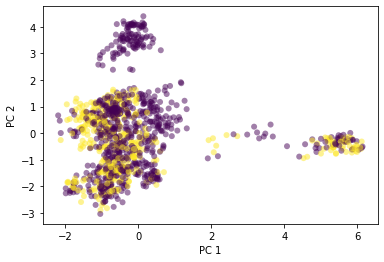

non-functional sequences are in dark violet, functional sequences are in yellow


In [ ]:
import matplotlib.pyplot as plt

plt.scatter(Xproj[:, 0], Xproj[:, 1], c=y, alpha = 0.5, edgecolor='none')
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.show()
plt.rcParams.update({'font.size': 10})
print("non-functional sequences are in dark violet, functional sequences are in yellow")

We clearly see that - a part from the non-functional blob in the upper part of the plot - functional and non-functional natural sequences are **not** well separated in the PCA space.

In [ ]:
variances = pca.explained_variance_ratio_
print(variances[0:40])

[0.04337461 0.03301329]


The first two principal components only explain $\sim 7.7\%$ of the variance of the data. However we're dealing with a 1920-dimensional space and PCA is thus useful only for visualizing the data.

We proceed with the artificial sequences; we will store in an array `X_art` the properly encoded sequences and in `y_art`their labels.

In [ ]:
y_art, X_art = encode_fasta_file('/MSA_art.faa')

We now want to project the artificial sequences on the principal components obtained from the natural data.

In [ ]:
Xproj_art = pca.transform(X_art) # we're projecting the artificial on the PC basis obtained from the natural sequences 
print(X_art.shape)
print(Xproj_art.shape)

(1003, 1920)
(1003, 2)


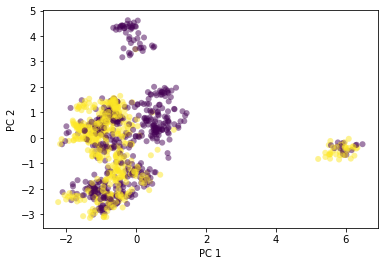

non-functional sequences are in dark violet, functional sequences are in yellow


In [ ]:
plt.scatter(Xproj_art[:, 0], Xproj_art[:, 1], c=y_art, alpha = 0.5, edgecolor='none')
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.show()
print("non-functional sequences are in dark violet, functional sequences are in yellow")

We clearly see that the artificially generated sequences occupy a similar region in the reduced sequence space.

##**Task 3: Clustering sequence data**

We try two of clustering algorithms that we've seen during the lectures **K-means** and **Gaussian mixture models**. For those two procedures we'll try to find the the best number of cluster in a qualitative way, test the robustness of algorithm and check if the resulting clustering carry some information about the functionality/non-functionality of the protein sequences under study.

We start with **K-means**:

In [ ]:
from sklearn.cluster import KMeans

def kmeans_clustering(n_clusters):
  est = KMeans(n_clusters)
  est.fit(X)
  y_kmeans = est.predict(X)
  center_proj = pca.transform(est.cluster_centers_)
  plt.scatter(Xproj[:, 0], Xproj[:, 1], c=y_kmeans, s=50, cmap='rainbow', edgecolor='black', alpha=0.5, linewidth=1);
  plt.scatter(center_proj[:,0], center_proj[:,1], s=250, color="gold", edgecolor='black', linewidth=3); # Show the centers
  plt.xlabel("PC 1")
  plt.ylabel("PC 2")

  plt.show()
from ipywidgets import interact
interact(kmeans_clustering, n_clusters=(1, 15));

interactive(children=(IntSlider(value=8, description='n_clusters', max=15, min=1), Output()), _dom_classes=('w…

Looking qualitatively at the first two principal components it appears that the number of cluster for which we have the best separation is 3.

We now check the robustness of this K-means clustering procedure. We know that the K-means *expectation-maximization tecnique* always converges to a local minimum of the cost function $\mathcal{C}$, and may thus be initialization-dependent. 



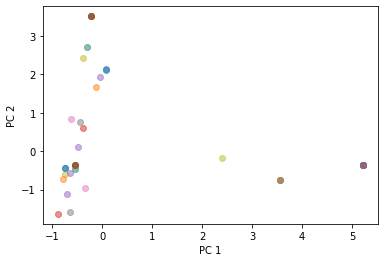

In [ ]:
for i in range(15):
  est = KMeans(3)
  est.fit(X)
  center_proj = pca.transform(est.cluster_centers_)
  plt.scatter(center_proj[:,0], center_proj[:,1], alpha = 0.5)
  plt.xlabel("PC 1")
  plt.ylabel("PC 2")

From this scattered distribution of the cluster centers for different initializations (different colors represent different initializations) we see that the clustering procedure is not robust, for different initializations we get different clusters, with a high variability.

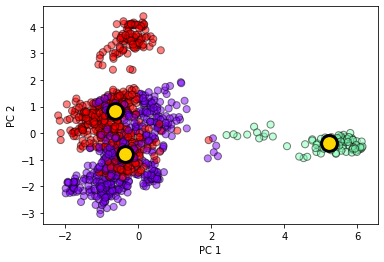

In [ ]:
est = KMeans(3)
est.fit(X)
y_kmeans = est.predict(X)
center_proj = pca.transform(est.cluster_centers_)
plt.scatter(Xproj[:, 0], Xproj[:, 1], c=y_kmeans, s=50, cmap='rainbow', edgecolor='black', alpha=0.5, linewidth=1)
plt.scatter(center_proj[:,0], center_proj[:,1], s=250, color="gold", edgecolor='black', linewidth=3)
plt.xlabel("PC 1")
plt.ylabel("PC 2")

plt.show()

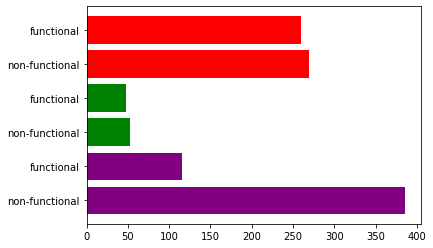

In [ ]:
funct_and_cluster = 3*y+y_kmeans

#EXPLANATION:
# funct_and_cluster[i] == 0 -> X[i] is a non-functional sequence in cluster 0
# funct_and_cluster[i] == 1 -> X[i] is a non-functional sequence in cluster 1
# funct_and_cluster[i] == 2 -> X[i] is a non-functional sequence in cluster 2
# funct_and_cluster[i] == 3 -> X[i] is a functional sequence in cluster 0
# funct_and_cluster[i] == 4 -> X[i] is a functional sequence in cluster 1
# funct_and_cluster[i] == 5 -> X[i] is a functional sequence in cluster 2

n_nonfun_and_0 = len(X[funct_and_cluster==0])
n_nonfun_and_1 = len(X[funct_and_cluster==1])
n_nonfun_and_2 = len(X[funct_and_cluster==2])
n_fun_and_0 = len(X[funct_and_cluster==3])
n_fun_and_1 = len(X[funct_and_cluster==4])
n_fun_and_2 = len(X[funct_and_cluster==5])

x=[n_nonfun_and_0, n_fun_and_0, n_nonfun_and_1, n_fun_and_1, n_nonfun_and_2, n_fun_and_2]
plt.barh([1,2,3,4,5,6],x, color=['purple','purple','green','green','red','red'], tick_label=['non-functional','functional','non-functional','functional','non-functional','functional'])

plt.show()

We see that functional and non-functional sequences are distributed in all three cluster, with the same proportions between funct. and non-funct. in the first two clusters. A part from the relative abundance of non-functional sequences in one of the cluster we can conclude that K-means clustering with 3 clusters does not capture anything meaningful about our data (at least not about functionality).

The only noticeable feature is the effect of the previously mentoned non-functional blob. However this blob is not well separated from the in the clustering procedure.

We proceed now with **GMM models**:

In [ ]:
from sklearn.mixture import GaussianMixture as GMM

def gmm_clustering(n_clusters):
  clf = GMM(n_clusters, max_iter=500).fit(X)
  #store the centers:
  centers_means_proj = pca.transform(clf.means_)
  plt.scatter(Xproj[:, 0], Xproj[:, 1], c=clf.predict(X), s=50, cmap='rainbow', edgecolor='black', alpha=0.5, linewidth=1)
  plt.scatter(centers_means_proj[:,0], centers_means_proj[:,1], s=250, color="gold", edgecolor='black', linewidth=3)
  plt.xlabel("PC 1")
  plt.ylabel("PC 2")

  plt.show()

from ipywidgets import interact
interact(gmm_clustering, n_clusters=(1, 5));



interactive(children=(IntSlider(value=3, description='n_clusters', max=5, min=1), Output()), _dom_classes=('wi…

Again from the visualization in the first to principal components it seems that the clustering procedure is not able capture any structure in our data. 

We can exploit Bayes (BIC) and Akaike (AIK) Information Criteria to evaluate how well the GM clustering procedure with different # of clusters fit our data. The two criteria evaluate the log-likelihood of the data with a term penalizing models with an high number of parameters:
$$ \text{AIC} = -2\times\log\big(\hat{L}\big) + 2\times K $$
$$ \text{BIC} = -2\times\log\big(\hat{L}\big) + K\times\log(n) $$
Where $\hat{L}$ is the maximum likelihood of the model, $K$ the number of parameters of the model, in our case the # of clusters and $n$ the numerosity of our dataset. We look for a minimum of this two parameters.

In [ ]:
n_clusters = np.arange(1, 6)
clfs = [GMM(n, max_iter=5000).fit(X) for n in n_clusters]     # method to create a list of models
bics = [clf.bic(X) for clf in clfs] 
aics = [clf.aic(X) for clf in clfs]


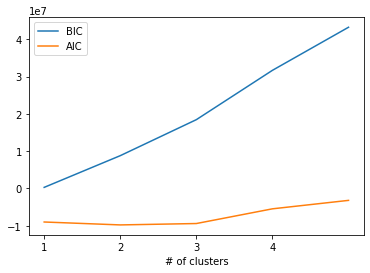

In [ ]:
plt.plot(n_clusters, bics, label='BIC')
plt.plot(n_clusters, aics, label='AIC')
plt.xlabel("# of clusters")
plt.xticks(np.arange(1, 5, step=1))
plt.legend();

From this results we see that the none of the number of clusters captures a clear structure. We note that AIC has an elbow in $K=3$, this reassures us (not so much) about the choice of 3 clusters as the best way to group our data done with K-means.

Again we see that the clustering with $K=3$ does not carry any information on the functionality of the sequences in the different clusters.

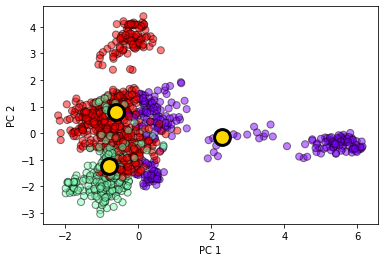

In [ ]:
clf = GMM(3, max_iter=1000).fit(X)
#store the centers:
centers_means_proj = pca.transform(clf.means_)
plt.scatter(Xproj[:, 0], Xproj[:, 1], c=clf.predict(X), s=50, cmap='rainbow', edgecolor='black', alpha=0.5, linewidth=1)
plt.scatter(centers_means_proj[:,0], centers_means_proj[:,1], s=250, color="gold", edgecolor='black', linewidth=3)
plt.xlabel("PC 1")
plt.ylabel("PC 2")

plt.show()

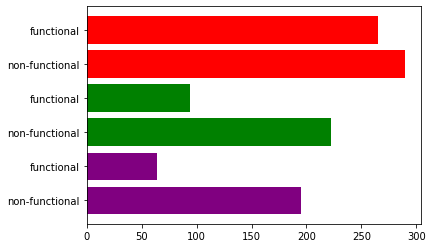

In [ ]:
funct_and_cluster = 3*y+clf.predict(X)

#EXPLANATION:
# funct_and_cluster[i] == 0 -> X[i] is a non-functional sequence in cluster 0
# funct_and_cluster[i] == 1 -> X[i] is a non-functional sequence in cluster 1
# funct_and_cluster[i] == 2 -> X[i] is a non-functional sequence in cluster 2
# funct_and_cluster[i] == 3 -> X[i] is a functional sequence in cluster 0
# funct_and_cluster[i] == 4 -> X[i] is a functional sequence in cluster 1
# funct_and_cluster[i] == 5 -> X[i] is a functional sequence in cluster 2

n_nonfun_and_0 = len(X[funct_and_cluster==0])
n_nonfun_and_1 = len(X[funct_and_cluster==1])
n_nonfun_and_2 = len(X[funct_and_cluster==2])
n_fun_and_0 = len(X[funct_and_cluster==3])
n_fun_and_1 = len(X[funct_and_cluster==4])
n_fun_and_2 = len(X[funct_and_cluster==5])

x=[n_nonfun_and_0, n_fun_and_0, n_nonfun_and_1, n_fun_and_1, n_nonfun_and_2, n_fun_and_2]
plt.barh([1,2,3,4,5,6],x, color=['purple','purple','green','green','red','red'], tick_label=['non-functional','functional','non-functional','functional','non-functional','functional'])

plt.show()

*Note that this histogram, as the one presented before for the K-means is defined on a single initialization of the clustering algorithm. We say that the clustering procedures are not capturing any structure in our data and are initialization, so this results are not very significant, still we've verified the this same behaviour (majority of the data in one of the clusters and functional and non-functional distributed in all clusters without significant distinctions) for several runs.*

The disappoint results obtained with **K-means** and **GM** highlight the known fact that clustering data in high-dimensions (our data are 1920-dimensional sparse vectors) can be very challenging. 

We proceed repeating the clustering procedure (only K-means) unifying the natural and artificial sequences into one large dataset. 

In [ ]:
X_tot = np.concatenate((X, X_art), axis = 0)
est = KMeans(3)
est.fit(X_tot)
center_proj = pca.transform(est.cluster_centers_)

y_kmeans_nat = est.predict(X)
y_kmeans_art = est.predict(X_art)

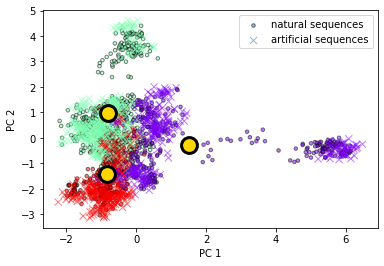

In [ ]:
plt.scatter(Xproj[:, 0], Xproj[:, 1], c=y_kmeans_nat, s=50, cmap='rainbow', edgecolor='black', alpha=0.5, linewidth=1, marker='.', label = 'natural sequences')
plt.scatter(Xproj_art[:, 0], Xproj_art[:, 1], c=y_kmeans_art, s=50, cmap='rainbow', edgecolor='black', alpha=0.5, linewidth=1, marker='x', label = 'artificial sequences')
plt.scatter(center_proj[:,0], center_proj[:,1], s=250, color="gold", edgecolor='black', linewidth=3)
plt.xlabel("PC 1")
plt.ylabel("PC 2")

plt.legend()

plt.show()

We recongnize the same result obtained considering only the natural sequences.

We check also that artificial and natural sequences are **not** separated in the clustering procedure:

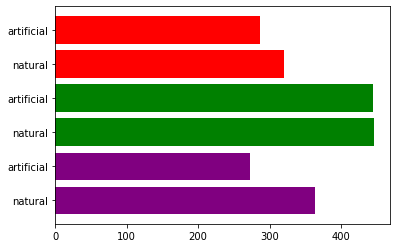

In [ ]:
n_nat_and_0 = len(X[y_kmeans_nat==0])
n_nat_and_1 = len(X[y_kmeans_nat==1])
n_nat_and_2 = len(X[y_kmeans_nat==2])
n_art_and_0 = len(X_art[y_kmeans_art==0])
n_art_and_1 = len(X_art[y_kmeans_art==1])
n_art_and_2 = len(X_art[y_kmeans_art==2])

x=[n_nat_and_0, n_art_and_0, n_nat_and_1, n_art_and_1, n_nat_and_2, n_art_and_2]
plt.barh([1,2,3,4,5,6],x, color=['purple','purple','green','green','red','red'], tick_label=['natural','artificial','natural','artificial','natural','artificial'])

plt.show()

## **Task 4: Predicting protein functionality**

Now we try to apply some supervised learning methods to build a classifier that can distinguish functional/non-functional sequences. The first method we will try is Logistic Regression (used as a hard classifier with a threshold that will be regardes as a hyperparameter)

In [ ]:
from sklearn.linear_model import LogisticRegression

# function that implements a hard classifier with threshold based on Logistic Regression
# T is the threshold, proba is the LR model predicted probabilities already fitted on data and X the data

def LR_threshold(proba,T=0.5):
  y_p = []
  for i in range(len(proba)):
    if proba[i,1] > T:
      y_p.append(1)
    else :
      y_p.append(0)
  return y_p

#define a score function for the hard classifier with threshold
def error(y,y_p):
  errors = 0.0
  for i in range(len(y)):
    if y[i]!=y_p[i]:
      errors+=1.0
  return errors*1.0/len(y)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2)
model = LogisticRegression(max_iter = 1000) 

In [ ]:
#implement a validation phase for the threshold

T_range = np.linspace(0.1,0.9,10)

scores_train = np.zeros(len(T_range))
scores_val = np.zeros(len(T_range))
"""
for (i,t) in enumerate(T_range):  
  for j in range(100):
    X_tt, X_tv, y_tt, y_tv = train_test_split(X_train,y_train, test_size = 0.2)
    model.fit(X_tt,y_tt)
    y_p_train = LR_threshold(model.predict_proba(X_tt),T=t)
    y_p_validation = LR_threshold(model.predict_proba(X_tv),T=t)
    scores_train[i] += error(y_tt,y_p_train)
    scores_val[i] += error(y_tv,y_p_validation)
  scores_train[i] = scores_train[i]/100
  scores_val[i] = scores_val[i]/100

plt.plot(T_range,scores_train, label='training error')
plt.plot(T_range,scores_val, label='validation error')
plt.xlabel("threshold")
plt.ylabel("error")
plt.legend()
plt.savefig('validation_curve_LR',dpi=300)
"""
# average procedure implemented because the curves were very noisy

'\nfor (i,t) in enumerate(T_range):  \n  for j in range(100):\n    X_tt, X_tv, y_tt, y_tv = train_test_split(X_train,y_train, test_size = 0.2)\n    model.fit(X_tt,y_tt)\n    y_p_train = LR_threshold(model.predict_proba(X_tt),T=t)\n    y_p_validation = LR_threshold(model.predict_proba(X_tv),T=t)\n    scores_train[i] += error(y_tt,y_p_train)\n    scores_val[i] += error(y_tv,y_p_validation)\n  scores_train[i] = scores_train[i]/100\n  scores_val[i] = scores_val[i]/100\n\nplt.plot(T_range,scores_train, label=\'training error\')\nplt.plot(T_range,scores_val, label=\'validation error\')\nplt.xlabel("threshold")\nplt.ylabel("error")\nplt.legend()\nplt.savefig(\'validation_curve_LR\',dpi=300)\n'

Evaluate the performance of the model with the best hyperparameter. We look at the probability of the assigned label to characterize the quality of the predictor.

0.00331858407079646
0.2168141592920354


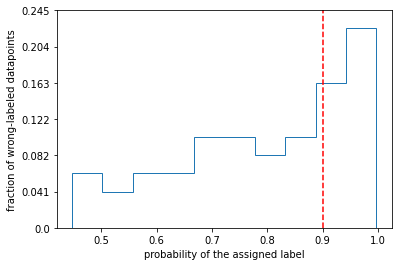

In [ ]:
model.fit(X_train,y_train)
y_p = LR_threshold(model.predict_proba(X_test),T=0.6)

# training error
print(error(LR_threshold(model.predict_proba(X_train),T=0.6),y_train))
#test error
print(error(np.array(y_p),y_test))


p = np.array([model.predict_proba(X_test)[i,y_p[i]] for i in range(len(y_p)) if y_p[i]!=y_test[i]])
plt.hist(p,bins=10,histtype='step')
locs, _ = plt.yticks()
plt.yticks(locs,np.round(locs/len(p),3))
plt.axvline(0.9,linestyle='--',color='r')
plt.xlabel('probability of the assigned label')
plt.ylabel('fraction of wrong-labeled datapoints')
plt.savefig('histogram.png',dpi=600)

In [ ]:
#compute error due to predicted labels that have more than 0.9 probability according
#to the LR soft classifier

p = np.array([model.predict_proba(X_test)[i,y_p[i]] for i in range(len(y_p))])

err = 0
num = 0
for i in range(len(y_p)):
  if  p[i]>0.9:
    num+=1
    if y_test[i]!=y_p[i]:
      err+=1.0
print(err*1.0/num)

# high variance, half of the wrong predictions have a very high probability

0.12080536912751678


In [ ]:
#implement a learning phase for the LR model

size = np.linspace(0.05,1,100, endpoint = False)
scores_train = np.zeros(len(size))
scores_test = np.zeros(len(size))
"""

for (i,t) in enumerate(size):  
  for j in range(100):
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = (1-t)) 
    model.fit(X_train,y_train)
    y_p_train = LR_threshold(model.predict_proba(X_train),T=0.6)
    y_p_test = LR_threshold(model.predict_proba(X_test),T=0.6)
    scores_train[i] += error(y_train,y_p_train)
    scores_test[i] += error(y_test,y_p_test)
  scores_train[i] = scores_train[i]/100
  scores_test[i] = scores_test[i]/100

plt.plot(size,scores_train, label='training error')
plt.plot(size,scores_test, label='test error')
plt.xlabel("size")
plt.ylabel("error")
plt.legend()
plt.savefig('learning_curve_LR.png',dpi=300)
"""
# average procedure implemented because the curves were very noisy
#try 0.5




'\n\nfor (i,t) in enumerate(size):  \n  for j in range(100):\n    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = (1-t)) \n    model.fit(X_train,y_train)\n    y_p_train = LR_threshold(model.predict_proba(X_train),T=0.6)\n    y_p_test = LR_threshold(model.predict_proba(X_test),T=0.6)\n    scores_train[i] += error(y_train,y_p_train)\n    scores_test[i] += error(y_test,y_p_test)\n  scores_train[i] = scores_train[i]/100\n  scores_test[i] = scores_test[i]/100\n\nplt.plot(size,scores_train, label=\'training error\')\nplt.plot(size,scores_test, label=\'test error\')\nplt.xlabel("size")\nplt.ylabel("error")\nplt.legend()\nplt.savefig(\'learning_curve_LR.png\',dpi=300)\n'

Evaluate the performance of the LR predictor applying it to the artificial sequences

In [ ]:
model.fit(X,y)
y_p = LR_threshold(model.predict_proba(X_art),T=0.6)
print(error(y_art,y_p))

print(X[[y[i]==1 for i in range(len(y))],:].shape)

0.22233300099700898
(423, 1920)


(504, 1920)
[[425  79]
 [144 355]]


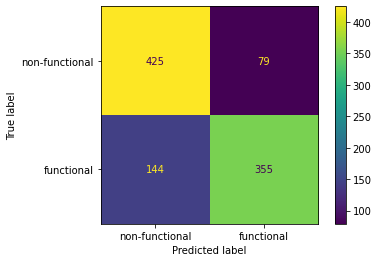

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(y_art, y_p)

print(X_art[[y_art[i]==0 for i in range(len(y_art))],:].shape)

print(cm)                                                  

disp=ConfusionMatrixDisplay(cm, display_labels=['non-functional','functional'])
disp.plot()
plt.grid(False)
plt.savefig('logistic_regression_CM.png',dpi=600)
plt.show()


Many signlas of high variance. We will try now to use Random Forest (Bagging) to try to reduce the problem

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2)

In [ ]:
#implement a validation phase for the depth of the trees

depth = np.linspace(1,40,40) 
scores_train = np.zeros(len(depth))
scores_val = np.zeros(len(depth))
"""
for (i,t) in enumerate(depth):  
  for j in range(80):
    X_tt, X_tv, y_tt, y_tv = train_test_split(X_train,y_train, test_size = 0.2)
    model_rf = RandomForestClassifier(n_estimators = 100, max_depth = t)
    model_rf.fit(X_tt,y_tt)
    scores_train[i] += 1-model_rf.score(X_tt,y_tt)
    scores_val[i] += 1-model_rf.score(X_tv,y_tv)
  scores_train[i] = scores_train[i]/80
  scores_val[i] = scores_val[i]/80


plt.plot(depth,scores_train, label='training error')
plt.plot(depth,scores_val, label='validation error')
plt.xlabel("max depth")
plt.ylabel("errors")
plt.legend()
plt.savefig('validation_curve_depth_RF.png',dpi=300)
"""

'\nfor (i,t) in enumerate(depth):  \n  for j in range(80):\n    X_tt, X_tv, y_tt, y_tv = train_test_split(X_train,y_train, test_size = 0.2)\n    model_rf = RandomForestClassifier(n_estimators = 100, max_depth = t)\n    model_rf.fit(X_tt,y_tt)\n    scores_train[i] += 1-model_rf.score(X_tt,y_tt)\n    scores_val[i] += 1-model_rf.score(X_tv,y_tv)\n  scores_train[i] = scores_train[i]/80\n  scores_val[i] = scores_val[i]/80\n\n\nplt.plot(depth,scores_train, label=\'training error\')\nplt.plot(depth,scores_val, label=\'validation error\')\nplt.xlabel("max depth")\nplt.ylabel("errors")\nplt.legend()\nplt.savefig(\'validation_curve_depth_RF.png\',dpi=300)\n'

In [ ]:
#implement a validation phase for the number of estimators

num = range(50,500,10) 
scores_train = np.zeros(len(num))
scores_val = np.zeros(len(num))
"""
for (i,t) in enumerate(num):  
  for j in range(40):
    X_tt, X_tv, y_tt, y_tv = train_test_split(X_train,y_train, test_size = 0.2)
    model_rf = RandomForestClassifier(n_estimators = t, max_depth = 10)
    model_rf.fit(X_tt,y_tt)
    scores_train[i] += 1-model_rf.score(X_tt,y_tt)
    scores_val[i] += 1-model_rf.score(X_tv,y_tv)
  scores_train[i] = scores_train[i]/40
  scores_val[i] = scores_val[i]/40


plt.plot(num,scores_train, label='training error')
plt.plot(num,scores_val, label='validation error')
plt.xlabel("num")
plt.ylabel("errors")
plt.legend()
"""

'\nfor (i,t) in enumerate(num):  \n  for j in range(40):\n    X_tt, X_tv, y_tt, y_tv = train_test_split(X_train,y_train, test_size = 0.2)\n    model_rf = RandomForestClassifier(n_estimators = t, max_depth = 10)\n    model_rf.fit(X_tt,y_tt)\n    scores_train[i] += 1-model_rf.score(X_tt,y_tt)\n    scores_val[i] += 1-model_rf.score(X_tv,y_tv)\n  scores_train[i] = scores_train[i]/40\n  scores_val[i] = scores_val[i]/40\n\n\nplt.plot(num,scores_train, label=\'training error\')\nplt.plot(num,scores_val, label=\'validation error\')\nplt.xlabel("num")\nplt.ylabel("errors")\nplt.legend()\n'

In [ ]:
# learning phase for the Random Forest Classifier

size = np.linspace(0.05,1,100, endpoint = False)
scores_train = np.zeros(len(size))
scores_test = np.zeros(len(size))
model_rf = RandomForestClassifier(n_estimators=100, max_depth=7)

"""

for (i,t) in enumerate(size): 
  for j in range(100):
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = (1-t))
    model_rf.fit(X_train,y_train) 
    scores_train[i] += 1-model_rf.score(X_train,y_train)
    scores_test[i] += 1-model_rf.score(X_test,y_test)
  scores_train[i] = scores_train[i]/100
  scores_test[i] = scores_test[i]/100


plt.plot(size,scores_train, label='training error')
plt.plot(size,scores_test, label='test error')
plt.xlabel("size")
plt.ylabel("errors")
plt.legend()
plt.savefig('learning_curve_RF.png',dpi=300)
"""


'\n\nfor (i,t) in enumerate(size): \n  for j in range(100):\n    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = (1-t))\n    model_rf.fit(X_train,y_train) \n    scores_train[i] += 1-model_rf.score(X_train,y_train)\n    scores_test[i] += 1-model_rf.score(X_test,y_test)\n  scores_train[i] = scores_train[i]/100\n  scores_test[i] = scores_test[i]/100\n\n\nplt.plot(size,scores_train, label=\'training error\')\nplt.plot(size,scores_test, label=\'test error\')\nplt.xlabel("size")\nplt.ylabel("errors")\nplt.legend()\nplt.savefig(\'learning_curve_RF.png\',dpi=300)\n'

In [ ]:
model_rf = RandomForestClassifier(n_estimators = 100, max_depth = 10)
model_rf.fit(X_train,y_train)

print(model_rf.score(X_test,y_test))

0.7920353982300885


In [ ]:
# build the probability distribution of the score since it's a random variable

import scipy as sp
from scipy.stats import norm
import matplotlib.mlab as mlab
"""
data = []

for i in range(1000):

  model_rf.fit(X,y)

  data.append(model_rf.score(X_art,y_art))


(mu, sigma) = norm.fit(data)

n, bins, patches=plt.hist(data,bins=100,histtype='step',alpha=0.75)

y = norm.pdf( bins, mu, sigma)
l = plt.plot(bins, y, 'r--', linewidth=2)

plt.xlabel("score")
plt.ylabel("empirical frequency")
locs, _ = plt.yticks()
plt.yticks(locs,np.round(locs/len(data),3))
plt.savefig('score.png',dpi=600)
"""

'\ndata = []\n\nfor i in range(1000):\n\n  model_rf.fit(X,y)\n\n  data.append(model_rf.score(X_art,y_art))\n\n\n(mu, sigma) = norm.fit(data)\n\nn, bins, patches=plt.hist(data,bins=100,histtype=\'step\',alpha=0.75)\n\ny = norm.pdf( bins, mu, sigma)\nl = plt.plot(bins, y, \'r--\', linewidth=2)\n\nplt.xlabel("score")\nplt.ylabel("empirical frequency")\nlocs, _ = plt.yticks()\nplt.yticks(locs,np.round(locs/len(data),3))\nplt.savefig(\'score.png\',dpi=600)\n'

[[435  69]
 [153 346]]


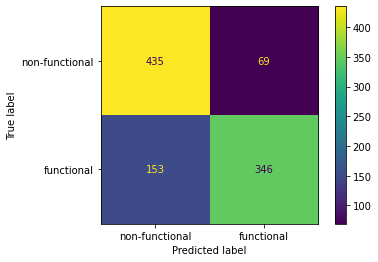

In [ ]:
model_rf.fit(X,y)
cm = confusion_matrix(y_art,model_rf.predict(X_art))

print(cm)                                                  

disp=ConfusionMatrixDisplay(cm, display_labels=['non-functional','functional'])
disp.plot()
plt.grid(False)
plt.savefig('random_forest_CM.png',dpi=600)
plt.show()


Try also Adaboost since in the results of Logistic Regression we have seen that half of the data were "hard" to classify

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2)

In [ ]:
#implement a validation phase for the depth of the trees

depth = np.linspace(1,30,30) 
scores_train = np.zeros(len(depth))
scores_val = np.zeros(len(depth))
"""
for (i,t) in enumerate(depth):  
  for j in range(80):
    X_tt, X_tv, y_tt, y_tv = train_test_split(X_train,y_train, test_size = 0.2)
    weak_c = DecisionTreeClassifier(max_depth = t)
    strong_c = AdaBoostClassifier(n_estimators = 100, base_estimator = weak_c )
    strong_c.fit(X_tt,y_tt)
    scores_train[i] += 1-strong_c.score(X_tt,y_tt)
    scores_val[i] += 1-strong_c.score(X_tv,y_tv)
  scores_train[i] = scores_train[i]/80
  scores_val[i] = scores_val[i]/80

plt.plot(depth,scores_train, label='training error')
plt.plot(depth,scores_val, label='validation error')
plt.xlabel("max depth")
plt.ylabel("errors")
plt.legend()
plt.savefig('validation_curve_depth_AB.png',dpi=300)
"""

'\nfor (i,t) in enumerate(depth):  \n  for j in range(80):\n    X_tt, X_tv, y_tt, y_tv = train_test_split(X_train,y_train, test_size = 0.2)\n    weak_c = DecisionTreeClassifier(max_depth = t)\n    strong_c = AdaBoostClassifier(n_estimators = 100, base_estimator = weak_c )\n    strong_c.fit(X_tt,y_tt)\n    scores_train[i] += 1-strong_c.score(X_tt,y_tt)\n    scores_val[i] += 1-strong_c.score(X_tv,y_tv)\n  scores_train[i] = scores_train[i]/80\n  scores_val[i] = scores_val[i]/80\n\nplt.plot(depth,scores_train, label=\'training error\')\nplt.plot(depth,scores_val, label=\'validation error\')\nplt.xlabel("max depth")\nplt.ylabel("errors")\nplt.legend()\nplt.savefig(\'validation_curve_depth_AB.png\',dpi=300)\n'

In [ ]:
#implement a validation phase for the of the number of estimators

num = range(50,500,10) 
scores_train = np.zeros(len(num))
scores_val = np.zeros(len(num))
"""
for (i,t) in enumerate(num):  
  for j in range(40):
    X_tt, X_tv, y_tt, y_tv = train_test_split(X_train,y_train, test_size = 0.2)
    weak_c = DecisionTreeClassifier(max_depth = 12)
    strong_c = AdaBoostClassifier(n_estimators = t, base_estimator = weak_c )
    strong_c.fit(X_tt,y_tt)
    scores_train[i] += 1-strong_c.score(X_tt,y_tt)
    scores_val[i] += 1-strong_c.score(X_tv,y_tv)
  scores_train[i] = scores_train[i]/40
  scores_val[i] = scores_val[i]/40


plt.plot(num,scores_train, label='training error')
plt.plot(num,scores_val, label='validation error')
plt.xlabel("num")
plt.ylabel("errors")
plt.legend()
"""

'\nfor (i,t) in enumerate(num):  \n  for j in range(40):\n    X_tt, X_tv, y_tt, y_tv = train_test_split(X_train,y_train, test_size = 0.2)\n    weak_c = DecisionTreeClassifier(max_depth = 12)\n    strong_c = AdaBoostClassifier(n_estimators = t, base_estimator = weak_c )\n    strong_c.fit(X_tt,y_tt)\n    scores_train[i] += 1-strong_c.score(X_tt,y_tt)\n    scores_val[i] += 1-strong_c.score(X_tv,y_tv)\n  scores_train[i] = scores_train[i]/40\n  scores_val[i] = scores_val[i]/40\n\n\nplt.plot(num,scores_train, label=\'training error\')\nplt.plot(num,scores_val, label=\'validation error\')\nplt.xlabel("num")\nplt.ylabel("errors")\nplt.legend()\n'

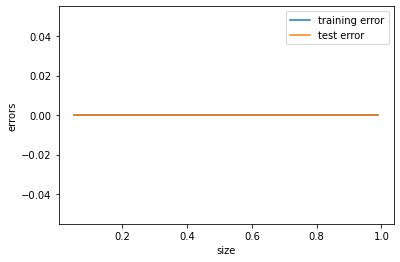

In [ ]:
# learning phase for the AdaBoost Classifier

size = np.linspace(0.05,1,100, endpoint = False)
scores_train = np.zeros(len(size))
scores_test = np.zeros(len(size))
weak_c = DecisionTreeClassifier(max_depth=15)
model_ab = AdaBoostClassifier(n_estimators=100, base_estimator=weak_c)

"""

for (i,t) in enumerate(size): 
  for j in range(40):
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = (1-t))
    model_ab.fit(X_train,y_train) 
    scores_train[i] += 1-model_ab.score(X_train,y_train)
    scores_test[i] += 1-model_ab.score(X_test,y_test)
  scores_train[i] = scores_train[i]/40
  scores_test[i] = scores_test[i]/40

"""
plt.plot(size,scores_train, label='training error')
plt.plot(size,scores_test, label='test error')
plt.xlabel("size")
plt.ylabel("errors")
plt.legend()
plt.savefig('learning_curve_AB.png',dpi=600)


In [ ]:
weak_c = DecisionTreeClassifier(max_depth=15)
strong_c = AdaBoostClassifier(n_estimators=100, base_estimator=weak_c)

strong_c.fit(X_train,y_train)

print(strong_c.score(X_test,y_test))

0.8053097345132744


In [ ]:
strong_c.fit(X,y)

print(strong_c.score(X_art,y_art))

0.7976071784646062


[[430  74]
 [129 370]]


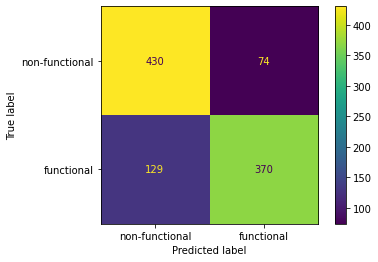

In [ ]:
cm = confusion_matrix(y_art,strong_c.predict(X_art))

print(cm)                                                  

disp=ConfusionMatrixDisplay(cm, display_labels=['non-functional','functional'])
disp.plot()
plt.grid(False)
plt.savefig('AdaBoost_CM.png',dpi=600)
plt.show()


## **Task 5: Generative model**

PLA part

In [ ]:
X_gen = np.load('/samples.npy') #sequences sampled from the generative model (100.000.000 run)
gen = np.concatenate((np.zeros(len(X)),np.ones(1000)))

Z = np.array([np.vstack((X,X_gen[j,:,:])) for j in range(X_gen.shape[0])])
pca.fit(Z[0]) #find principal components on one sample
Z_proj= np.array([pca.transform(Z[j]) for j in range(X_gen.shape[0])])

def compare_seq(j):
  plt.scatter(Z_proj[j,gen==0, 0], Z_proj[j,gen==0, 1], marker='.', alpha = 0.5, 
            edgecolor='none',label='natural')
  plt.scatter(Z_proj[j,gen==1, 0], Z_proj[j,gen==1, 1], marker='x', alpha = 0.5, 
            edgecolor='none',label='generated')
  plt.xlabel("PC 1")
  plt.ylabel("PC 2")
  plt.legend()
  plt.show()
  

from ipywidgets import interact
interact(compare_seq, j=(0, 9));

print("natural sequences are in dark violet, generated sequences are in yellow")

interactive(children=(IntSlider(value=4, description='j', max=9), Output()), _dom_classes=('widget-interact',)…

natural sequences are in dark violet, generated sequences are in yellow


In [ ]:
#try to apply the previously trained predictors on the generated data

#count the number of ones in the predicted labels
def count_functional(y):
  ones=0
  for i in range(len(y)):
    if y[i]==1:
      ones+=1
  return ones/len(y)

def functionality(X_gen):
  for i in range(X_gen.shape[0]):
    print("sample "+str(i)+":")
    y_ab = strong_c.predict(X_gen[i])
    print("fraction of functional sequences (AB): "+str(count_functional(y_ab))) 
    y_lr = LR_threshold(X_gen[i],0.6)
    print("fraction of functional sequences (LR): "+str(count_functional(y_lr)))
    y_rf = model_rf.predict(X_gen[i])
    print("fraction of functional sequences (RF): "+str(count_functional(y_rf))) 

functionality(X_gen)

sample 0:
fraction of functional sequences (AB): 0.132
fraction of functional sequences (LR): 0.005
fraction of functional sequences (RF): 0.025
sample 1:
fraction of functional sequences (AB): 0.11
fraction of functional sequences (LR): 0.003
fraction of functional sequences (RF): 0.037
sample 2:
fraction of functional sequences (AB): 0.125
fraction of functional sequences (LR): 0.001
fraction of functional sequences (RF): 0.023
sample 3:
fraction of functional sequences (AB): 0.125
fraction of functional sequences (LR): 0.002
fraction of functional sequences (RF): 0.039
sample 4:
fraction of functional sequences (AB): 0.107
fraction of functional sequences (LR): 0.001
fraction of functional sequences (RF): 0.033
sample 5:
fraction of functional sequences (AB): 0.117
fraction of functional sequences (LR): 0.002
fraction of functional sequences (RF): 0.029
sample 6:
fraction of functional sequences (AB): 0.135
fraction of functional sequences (LR): 0.0
fraction of functional sequences 

Taking in account the accuracy of the predictor we cannot be sure about the real number of functional sequences

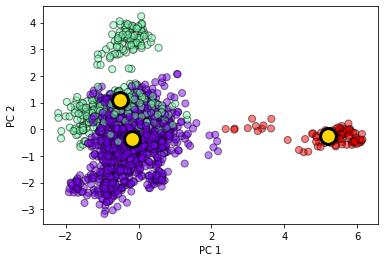

In [ ]:
est = KMeans(3)
est.fit(Z[0])
y_kmeans = est.predict(Z[0])
center_proj = pca.transform(est.cluster_centers_)
plt.scatter(Z_proj[0,:, 0], Z_proj[0,:, 1], c=y_kmeans, s=50, cmap='rainbow', edgecolor='black', alpha=0.5, linewidth=1)
plt.scatter(center_proj[:,0], center_proj[:,1], s=250, color="gold", edgecolor='black', linewidth=3)
plt.xlabel("PC 1")
plt.ylabel("PC 2")

plt.show()

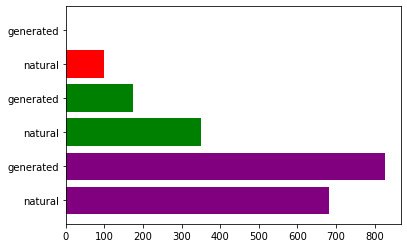

In [ ]:
#EXPLANATION:
# origin_and_cluster[i] == 0 -> X[i] is a natural sequence in cluster 0
# origin_and_cluster[i] == 1 -> X[i] is a natural sequence in cluster 1
# origin_and_cluster[i] == 2 -> X[i] is a natural sequence in cluster 2
# origin_and_cluster[i] == 3 -> X[i] is a generated sequence in cluster 0
# origin_and_cluster[i] == 4 -> X[i] is a generated sequence in cluster 1
# origin_and_cluster[i] == 5 -> X[i] is a generated sequence in cluster 2

n_gen_and_0 = []
n_gen_and_1 = []
n_gen_and_2 = []

for i in range(X_gen.shape[0]):
  y_means=est.predict(Z[i])
  origin_and_cluster = 3*gen+y_kmeans
  n_gen_and_0.append(len(Z[i,origin_and_cluster==3]))
  n_gen_and_1.append(len(Z[i][origin_and_cluster==4]))
  n_gen_and_2.append(len(Z[i][origin_and_cluster==5]))

n_gen_and_0 = np.average(np.array(n_gen_and_0))
n_gen_and_1 = np.average(np.array(n_gen_and_1))
n_gen_and_2 = np.average(np.array(n_gen_and_2))

n_nat_and_0 = len(Z[0][origin_and_cluster==0])
n_nat_and_1 = len(Z[0][origin_and_cluster==1])
n_nat_and_2 = len(Z[0][origin_and_cluster==2])

x=[n_nat_and_0, n_gen_and_0, n_nat_and_1, n_gen_and_1, n_nat_and_2, n_gen_and_2]
plt.barh([1,2,3,4,5,6],x, color=['purple','purple','green','green','red','red'], tick_label=['natural','generated','natural','generated','natural','generated'])
plt.savefig('clusters_fractions.png',dpi=600)
plt.show()

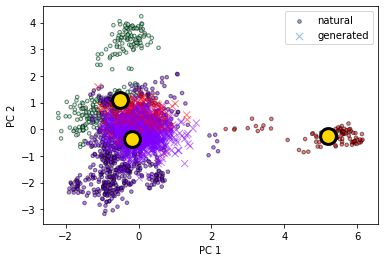

In [ ]:
plt.scatter(Z_proj[0,gen==0, 0], Z_proj[0,gen==0, 1], c=y_kmeans[gen==0], s=50, cmap='rainbow', label ='natural',
            edgecolor='black', alpha=0.5, linewidth=1,marker='.')
plt.scatter(Z_proj[0,gen==1, 0], Z_proj[0,gen==1, 1], c=y_kmeans[gen==1], s=50, cmap='rainbow', label = 'generated', 
            edgecolor='black', alpha=0.5, linewidth=1,marker='x')
plt.scatter(center_proj[:,0], center_proj[:,1], s=250, color="gold", edgecolor='black', linewidth=3)
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.legend()

plt.savefig('clusters_nat_and_gen.png',dpi=600)
plt.show()

Copied here part of the code from the generative models notebook

In [ ]:
from numba import jit

#some useful functions

L = len(X[1])
print("length of the sequences, L = ", L)
M = len(X)
print("number of sequences, M = ", M)
N = 21
print("number of characters/AAs, N = ", N)

#trasformation to Ising
@jit
def ising_transform(X):
    X_ising = X.copy()
    for m in range(len(X)):
        for i in range(L):
            if X[m,i] == A(i, X):
                X_ising[m,i] = 1
            else:
                X_ising[m,i] = -1
    return X_ising


def integer_transform(X, N, X_train):
    X_integer = X.copy()
    for m in range(len(X)):
        for i in range(len(X[0])):
            if X[m,i] == +1:
                X_integer[m,i] = A(i,X_train)
            else:
                AA_array = [i for i in range(0,21)]
                ind = AA_array.index(A(i,X_train))
                AA_array.pop(ind)
                p_array = [f(a, i, X_train) for a in range(N)]
                p_array.pop(ind)
                p_array = np.array(p_array)
                if p_array.sum() == 0: #deal with the case in which all p are 0
                    p_array = np.ones(len(AA_array))
                p_array /= p_array.sum()
                chosenAA = np.random.choice(a=AA_array, p=p_array)
                X_integer[m,i]= chosenAA
    return X_integer

def seq_from_int_to_onehot(sequence_int):
    sequence_onehot = []
    for i in range(len(sequence_int)):
        addition = np.zeros(20, dtype=int)
        if sequence_int[i] != 20:
            addition[sequence_int[i]]=1
        sequence_onehot.append(addition)
    return np.array(sequence_onehot).flatten()

def data_from_int_to_onehot(X):
    X_onehot=[]
    for i in X:
        X_onehot.append(seq_from_int_to_onehot(i))
    return np.array(X_onehot)

@jit
def delta(a,b):
    if a == b:
        return 1
    else:
        return 0

@jit
def f(a, i, X):
    tot = 0
    for m in range(M):
        tot = tot+delta(a, X[m,i])
    return tot/M

@jit
def A(i, X):
    f_array = []
    for a in range(N):
        F = f(a, i, X)
        f_array.append(F)
    f_array = np.array(f_array)
    return np.argmax(f_array)

def integer_encode_seq(sequence): #we can use instead of this the one-hot encoded function
    alphabet = ['A', 'C', 'D', 'E', 'F', 'G','H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y', '-']
    char_to_int = dict((c, i) for i, c in enumerate(alphabet))
    integer_encoded = [char_to_int[char] for char in sequence]
    return integer_encoded

def integer_encode_fasta_file(path_to_file):
    y = []
    X = []
    with open(path_to_file) as f:
        for line in f:
            line = line.strip() #removes blank spaces at the beginning and at the end of each line
            if not line:
                continue #does nothing if the line is empty
            if line.startswith(">"): #handles a label line
                text_sequence = '' #initializes the string in which we will store our sequence - trick to avoid messing up the two line sequence :)
                if line.endswith("true"):
                    y.append(1)
                elif line.endswith("false"):
                    y.append(0)
            else: #case in which we have the first line of a sequence or the second line of a sequence
                if len(text_sequence) == 0:
                    text_sequence = text_sequence + line
                else:
                    text_sequence = text_sequence + line
                    X.append(integer_encode_seq(text_sequence))
    return np.array(y), np.array(X)


length of the sequences, L =  1920
number of sequences, M =  1130
number of characters/AAs, N =  21


Observe how the consesus conversion influences the functionality of sequences

In [ ]:
y, X = integer_encode_fasta_file('/MSA_nat_with_annotation.faa')

X_ising = ising_transform(X)
X_int = integer_transform(X_ising,N,X)
X_back = data_from_int_to_onehot(X_int)

In [ ]:
y_ab = strong_c.predict(X_back)
print("fraction of functional sequences (AB): "+str(count_functional(y_ab))) 
y_lr = LR_threshold(X_back,0.6)
print("fraction of functional sequences (LR): "+str(count_functional(y_lr)))
y_rf = model_rf.predict(X_back)
print("fraction of functional sequences (RF): "+str(count_functional(y_rf)))


fraction of functional sequences (AB): 0.18938053097345134
fraction of functional sequences (LR): 0.0017699115044247787
fraction of functional sequences (RF): 0.09646017699115045


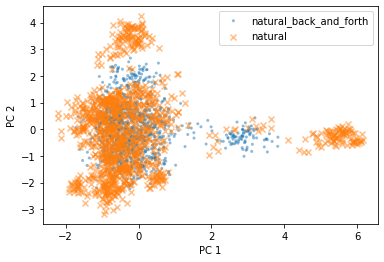

In [ ]:
X_back_proj = pca.transform(X_back)

plt.scatter(X_back_proj[:, 0], X_back_proj[:, 1], marker='.', alpha = 0.5, 
            edgecolor='none',label='natural_back_and_forth')
plt.scatter(Z_proj[0,gen==0, 0], Z_proj[0,gen==0, 1], marker='x', alpha = 0.5, 
            edgecolor='none',label='natural')
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.legend()
plt.savefig('consensus_effect.png',dpi=300)
plt.show()

Repeat the same as above for sequences generated using a pseudo maximum likelyhood method

In [ ]:
y, X = encode_fasta_file('/MSA_nat_with_annotation.faa')

X_gen = np.load('/PML_samples.npy') #sequences sampled from the generative model
gen = np.concatenate((np.zeros(len(X)),np.ones(1000)))

Z = np.array([np.vstack((X,X_gen[j,:,:])) for j in range(X_gen.shape[0])])

print(Z.shape)
pca.fit(Z[0]) #find principal components on one sample
Z_proj= np.array([pca.transform(Z[j]) for j in range(X_gen.shape[0])])

def compare_seq(j):
  plt.scatter(Z_proj[j,gen==0, 0], Z_proj[j,gen==0, 1], marker='.', alpha = 0.5, 
            edgecolor='none',label='natural')
  plt.scatter(Z_proj[j,gen==1, 0], Z_proj[j,gen==1, 1], marker='x', alpha = 0.5, 
            edgecolor='none',label='generated')
  plt.xlabel("PC 1")
  plt.ylabel("PC 2")
  plt.legend()
  plt.show()
  

from ipywidgets import interact
interact(compare_seq, j=(0, 9));

print("natural sequences are in dark violet, generated sequences are in yellow")

(10, 2130, 1920)


interactive(children=(IntSlider(value=4, description='j', max=9), Output()), _dom_classes=('widget-interact',)…

natural sequences are in dark violet, generated sequences are in yellow


In [ ]:
#try to apply the previously trained predictors on the generated data

#count the number of ones in the predicted labels
def count_functional(y):
  ones=0
  for i in range(len(y)):
    if y[i]==1:
      ones+=1
  return ones/len(y)

def functionality(X_gen):
  for i in range(X_gen.shape[0]):
    print("sample "+str(i)+":")
    y_ab = strong_c.predict(X_gen[i])
    print("fraction of functional sequences (AB): "+str(count_functional(y_ab))) 
    y_lr = LR_threshold(X_gen[i],0.6)
    print("fraction of functional sequences (LR): "+str(count_functional(y_lr)))
    y_rf = model_rf.predict(X_gen[i])
    print("fraction of functional sequences (RF): "+str(count_functional(y_rf))) 

functionality(X_gen)

sample 0:
fraction of functional sequences (AB): 0.146
fraction of functional sequences (LR): 0.0
fraction of functional sequences (RF): 0.13
sample 1:
fraction of functional sequences (AB): 0.138
fraction of functional sequences (LR): 0.0
fraction of functional sequences (RF): 0.11
sample 2:
fraction of functional sequences (AB): 0.152
fraction of functional sequences (LR): 0.001
fraction of functional sequences (RF): 0.093
sample 3:
fraction of functional sequences (AB): 0.129
fraction of functional sequences (LR): 0.0
fraction of functional sequences (RF): 0.095
sample 4:
fraction of functional sequences (AB): 0.15
fraction of functional sequences (LR): 0.001
fraction of functional sequences (RF): 0.11
sample 5:
fraction of functional sequences (AB): 0.15
fraction of functional sequences (LR): 0.0
fraction of functional sequences (RF): 0.111
sample 6:
fraction of functional sequences (AB): 0.122
fraction of functional sequences (LR): 0.0
fraction of functional sequences (RF): 0.097


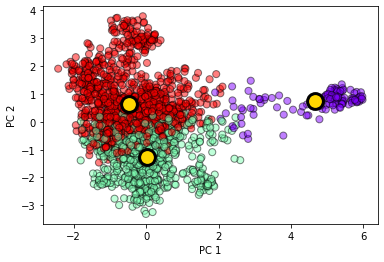

In [ ]:
est = KMeans(3)
est.fit(Z[0])
y_kmeans = est.predict(Z[0])
center_proj = pca.transform(est.cluster_centers_)
plt.scatter(Z_proj[0,:, 0], Z_proj[0,:, 1], c=y_kmeans, s=50, cmap='rainbow', edgecolor='black', alpha=0.5, linewidth=1)
plt.scatter(center_proj[:,0], center_proj[:,1], s=250, color="gold", edgecolor='black', linewidth=3)
plt.xlabel("PC 1")
plt.ylabel("PC 2")

plt.show()

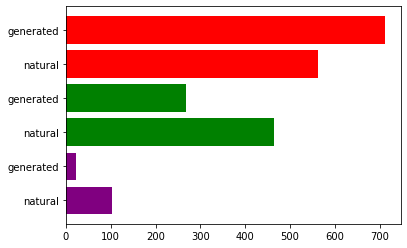

In [ ]:
#EXPLANATION:
# origin_and_cluster[i] == 0 -> X[i] is a natural sequence in cluster 0
# origin_and_cluster[i] == 1 -> X[i] is a natural sequence in cluster 1
# origin_and_cluster[i] == 2 -> X[i] is a natural sequence in cluster 2
# origin_and_cluster[i] == 3 -> X[i] is a generated sequence in cluster 0
# origin_and_cluster[i] == 4 -> X[i] is a generated sequence in cluster 1
# origin_and_cluster[i] == 5 -> X[i] is a generated sequence in cluster 2

n_gen_and_0 = []
n_gen_and_1 = []
n_gen_and_2 = []

for i in range(X_gen.shape[0]):
  y_means=est.predict(Z[i])
  origin_and_cluster = 3*gen+y_kmeans
  n_gen_and_0.append(len(Z[i,origin_and_cluster==3]))
  n_gen_and_1.append(len(Z[i][origin_and_cluster==4]))
  n_gen_and_2.append(len(Z[i][origin_and_cluster==5]))

n_gen_and_0 = np.average(np.array(n_gen_and_0))
n_gen_and_1 = np.average(np.array(n_gen_and_1))
n_gen_and_2 = np.average(np.array(n_gen_and_2))

n_nat_and_0 = len(Z[0][origin_and_cluster==0])
n_nat_and_1 = len(Z[0][origin_and_cluster==1])
n_nat_and_2 = len(Z[0][origin_and_cluster==2])

x=[n_nat_and_0, n_gen_and_0, n_nat_and_1, n_gen_and_1, n_nat_and_2, n_gen_and_2]
plt.barh([1,2,3,4,5,6],x, color=['purple','purple','green','green','red','red'], tick_label=['natural','generated','natural','generated','natural','generated'])
plt.savefig('clusters_fractions.png',dpi=600)
plt.show()

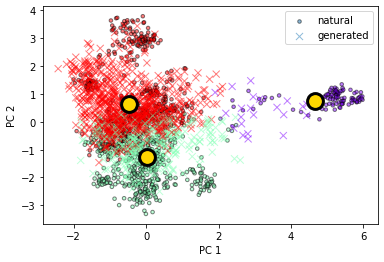

In [ ]:
plt.scatter(Z_proj[0,gen==0, 0], Z_proj[0,gen==0, 1], c=y_kmeans[gen==0], s=50, cmap='rainbow', label ='natural',
            edgecolor='black', alpha=0.5, linewidth=1,marker='.')
plt.scatter(Z_proj[0,gen==1, 0], Z_proj[0,gen==1, 1], c=y_kmeans[gen==1], s=50, cmap='rainbow', label = 'generated', 
            edgecolor='black', alpha=0.5, linewidth=1,marker='x')
plt.scatter(center_proj[:,0], center_proj[:,1], s=250, color="gold", edgecolor='black', linewidth=3)
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.legend()

plt.savefig('clusters_nat_and_gen.png',dpi=600)
plt.show()

Trying to add a "computational" temperature to the probability distribution to see if the fraction of functional sequences increases

In [ ]:
X_gen = np.load('/PML_sample_0.66.npy') #sequences sampled from the generative model
X_gen = np.vstack((X_gen,np.load('/PML_sample_0.33.npy')))
gen = np.concatenate((np.zeros(len(X)),np.ones(1000)))

Z = np.array([np.vstack((X,X_gen[j,:,:])) for j in range(X_gen.shape[0])])

print(Z.shape)
pca.fit(Z[0]) #find principal components on one sample
Z_proj= np.array([pca.transform(Z[j]) for j in range(X_gen.shape[0])])

def compare_seq(j):
  plt.scatter(Z_proj[j,gen==0, 0], Z_proj[j,gen==0, 1],  alpha = 1, 
            edgecolor='none',label='natural')
  plt.scatter(Z_proj[j,gen==1, 0], Z_proj[j,gen==1, 1],  alpha = 0.5, 
            edgecolor='none',label='generated')
  plt.xlabel("PC 1")
  plt.ylabel("PC 2")
  plt.legend()
  plt.show()
  
from ipywidgets import interact
interact(compare_seq, j=(0, 1));

(2, 2130, 1920)


interactive(children=(IntSlider(value=0, description='j', max=1), Output()), _dom_classes=('widget-interact',)…

In [ ]:
#try to apply the previously trained predictors on the generated data

#count the number of ones in the predicted labels
def count_functional(y):
  ones=0
  for i in range(len(y)):
    if y[i]==1:
      ones+=1
  return ones/len(y)

def functionality(X_gen):
  for i in range(X_gen.shape[0]):
    print("sample "+str(i)+":")
    y_ab = strong_c.predict(X_gen[i])
    print("fraction of functional sequences (AB): "+str(count_functional(y_ab))) 
    y_lr = LR_threshold(X_gen[i],0.6)
    print("fraction of functional sequences (LR): "+str(count_functional(y_lr)))
    y_rf = model_rf.predict(X_gen[i])
    print("fraction of functional sequences (RF): "+str(count_functional(y_rf))) 

functionality(X_gen)

sample 0:
fraction of functional sequences (AB): 0.179
fraction of functional sequences (LR): 0.0
fraction of functional sequences (RF): 0.128
sample 1:
fraction of functional sequences (AB): 0.204
fraction of functional sequences (LR): 0.0
fraction of functional sequences (RF): 0.183
